#LSTM AND BI-LSTM for Temperature Prediction

In [2]:
# pip install 

In [1]:
# import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset
# from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from utils import EarlyStopping,KAN,KANLinear,kan_prediction_plots
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
# import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(142)

/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [932]:
os.getcwd()

'/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Temperature'

**Data Importation and Information**

In [2]:
# data for Abidjan
parent_dir="/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data"
Abj_dt = pd.read_csv(parent_dir+'/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv(parent_dir+'/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_25783/326431376.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv(parent_dir+'/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_25783/326431376.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv(parent_dir+'/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [934]:
##### No missing for both datasets ###
# Abj_dt.isna().sum()
# Kgl_dt.isnull().sum()
Abj_dt.columns


Index(['datetime', 'ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS'],
      dtype='object')

In [935]:
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt=Kgl_dt.rename(columns=col_name_map)



In [936]:
print(Abj_dt.info())
print(Kgl_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5114 non-null   datetime64[ns]
 1   ASWD      5114 non-null   float64       
 2   CSWD      5114 non-null   float64       
 3   ALWD      5114 non-null   float64       
 4   T2M       5114 non-null   float64       
 5   T2MDEW    5114 non-null   float64       
 6   T2MWET    5114 non-null   float64       
 7   QV2M      5114 non-null   float64       
 8   RH2M      5114 non-null   float64       
 9   PREC      5114 non-null   float64       
 10  PS        5114 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 439.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5114 non-null 

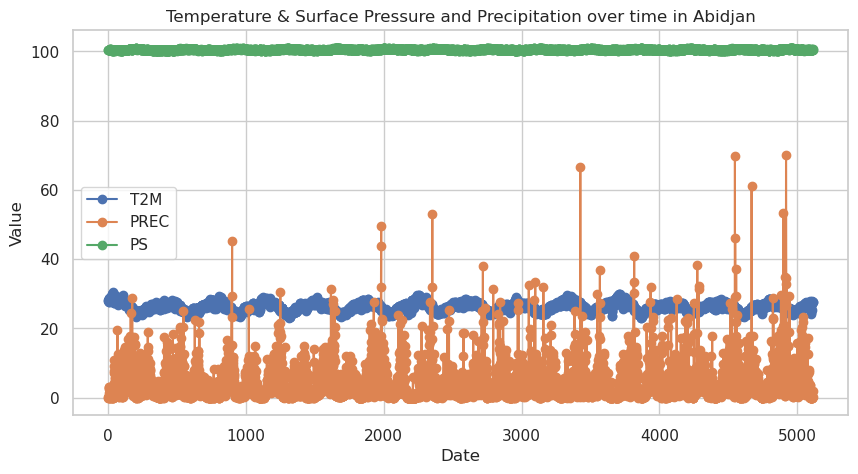

In [937]:
import pandas as pd
import matplotlib.pyplot as plt

# Select specific variables to plot
columns_to_plot = ['T2M', 'PREC','PS']

# Plot
Abj_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Abidjan')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()


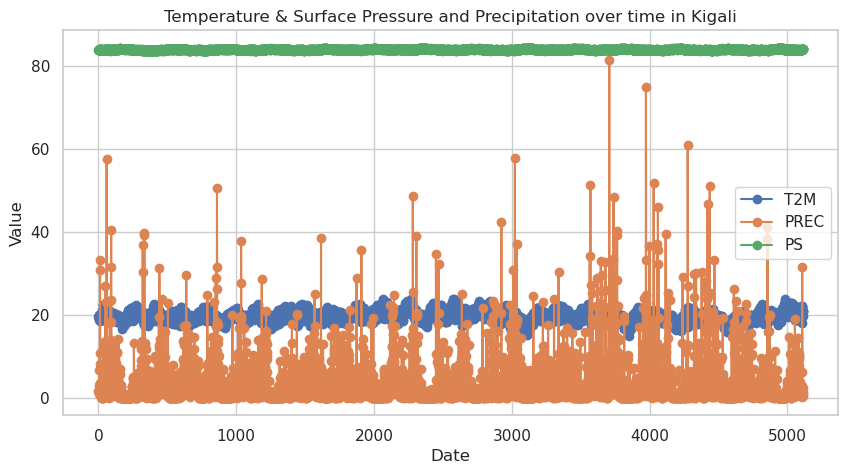

In [938]:
# Plot
Kgl_dt[columns_to_plot].plot(figsize=(10, 5), marker='o')
plt.title('Temperature & Surface Pressure and Precipitation over time in Kigali')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(columns_to_plot)
plt.grid(visible=True)
plt.show()

In [939]:
# # Plot
# df.plot(x='Date', y=columns_to_plot, figsize=(10, 5), marker='o')
# plt.title('Temperature & Humidity Over Time')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend(columns_to_plot)
# plt.grid()
# plt.show()

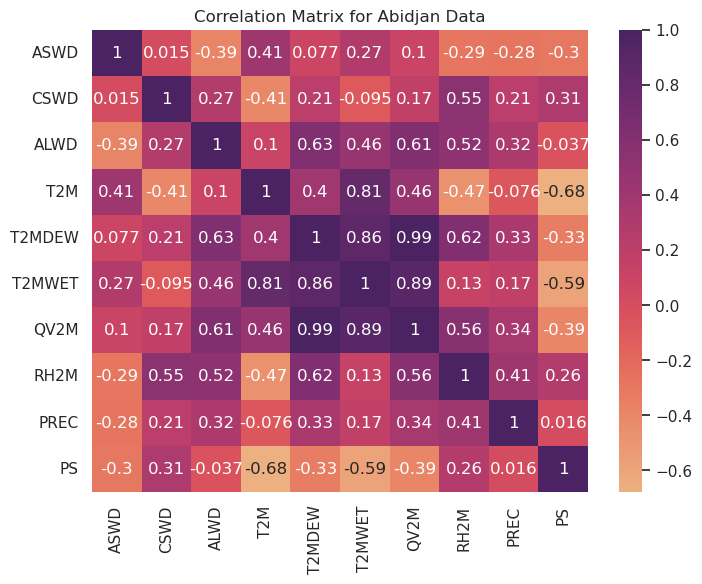

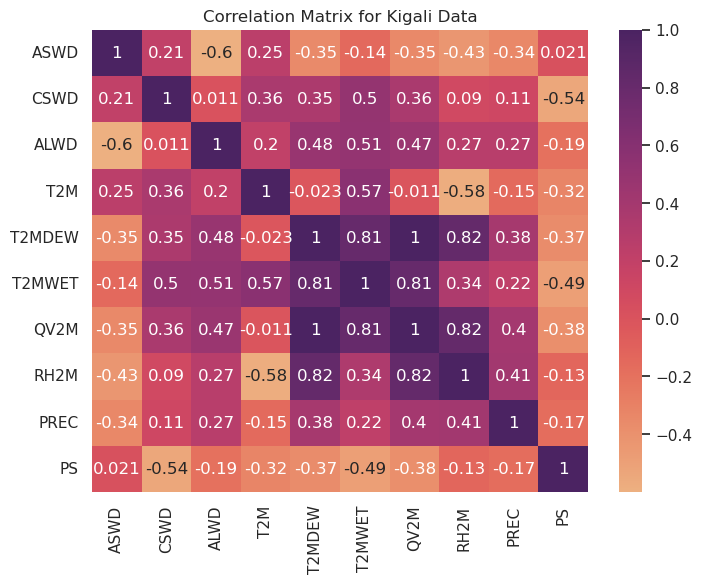

In [940]:
# df.columns,df_.columns
def displayHeatMap(dim1, dim2, title, df):
    fig=plt.figure(figsize=(dim1,dim2))
    plt.title(title)
    sns.heatmap(df, annot= True, cmap='flare')
# Define correlation matrix for both data
corr_Abj= Abj_dt.iloc[:,1:].corr()
corr_Kgl= Kgl_dt.iloc[:,1:].corr()
# Display the heatmap
displayHeatMap(8, 6,"Correlation Matrix for Abidjan Data",corr_Abj)
displayHeatMap(8, 6,"Correlation Matrix for Kigali Data",corr_Kgl)

In [941]:
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")

In [942]:
# Abj_dt.columns

**Variable ploting**

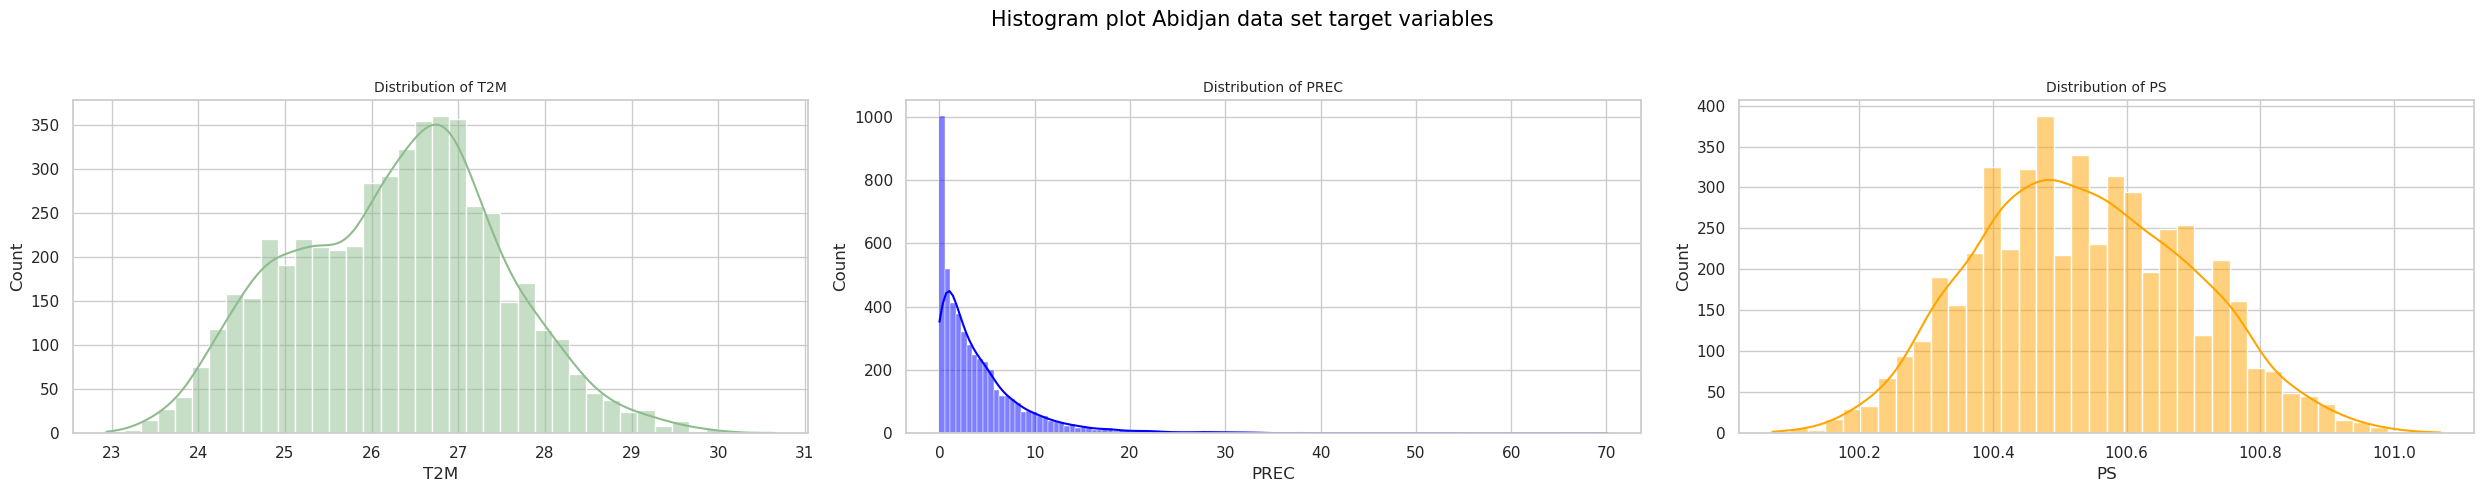

In [943]:
# df['Days'] = pd.to_datetime(df['Days'], dayfirst=True)
# df.index = pd.to_datetime(df['Days'],infer_datetime_format=True )
# plt.figure(figsize=(9,9))
# df.set_index('Days')[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
#        'CSSWDW', 'T2MDEW', 'ALLSKYDW']].plot(subplots=True)
#plotting histograms of each category to idenitfy patterns in the data
import matplotlib.pyplot as plt
import seaborn as sns

def showDistributions(df, categories, per_column=True, color=["darkseagreen", "blue", "orange"], title="Original Data"):
    if per_column:
        fig, axes = plt.subplots(1, len(categories), figsize=(25, 5))

        # Ensure color list length matches categories
        if isinstance(color, str):  
            color = [color] * len(categories)  # Convert single color to list
        elif len(color) != len(categories):
            raise ValueError("The length of the color list must match the number of categories.")

        for i in range(len(categories)):
            sns.histplot(data=df, x=categories[i], kde=True, color=color[i], ax=axes[i])
            axes[i].set_title(f"Distribution of {categories[i]}",fontsize=10)

        plt.suptitle(title, fontsize=15, color="black")  # Use a single color
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title

    else:
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.histplot(data=df, x=categories[0], kde=True, color=color[0], ax=ax)  # Use first category for plotting
        ax.set_title(f"Distribution of {categories[0]}")

    plt.show()


showDistributions(Abj_dt,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

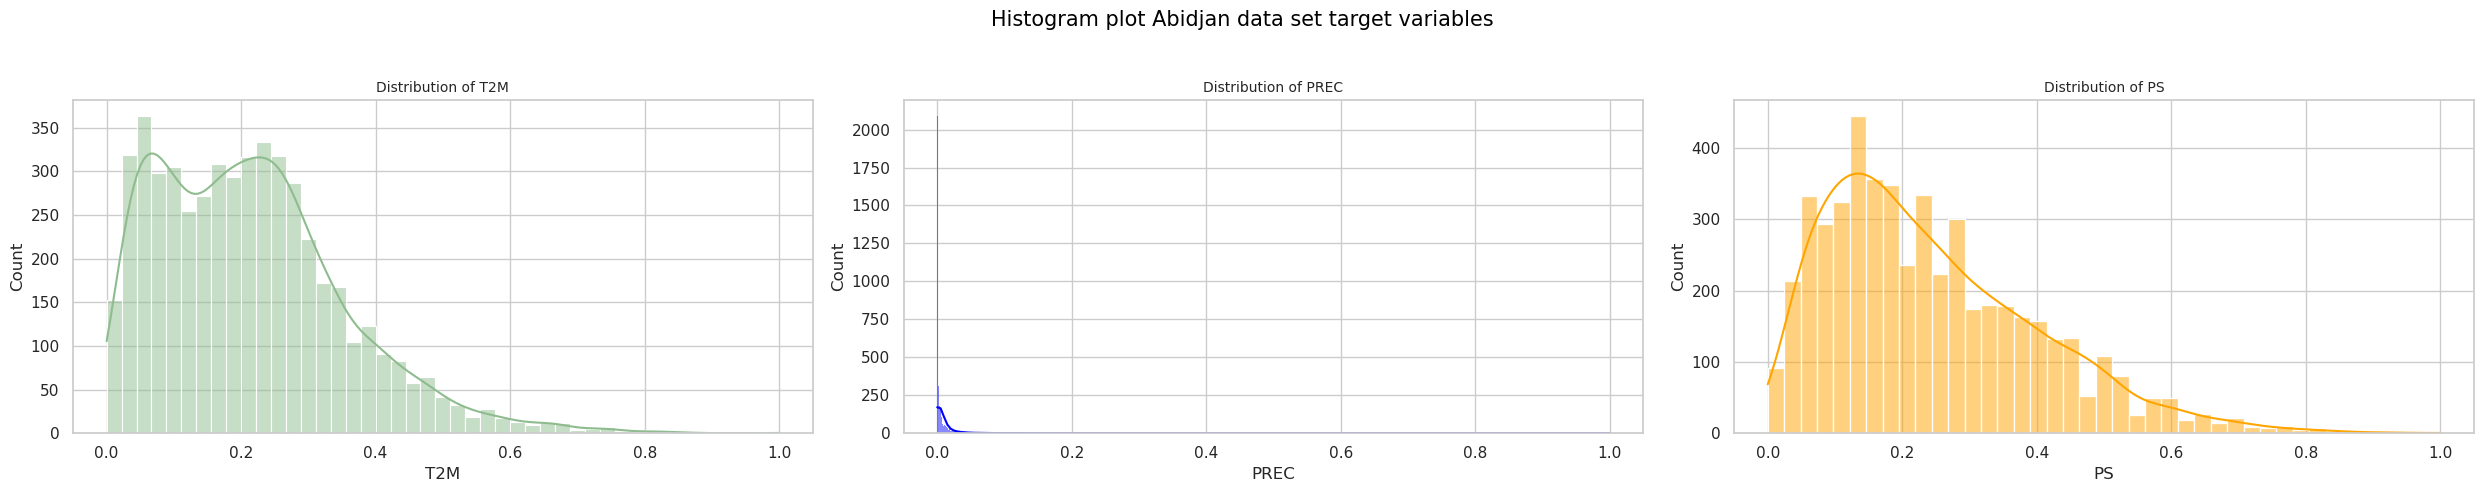

In [1017]:
import copy
Abj_dt_=copy.deepcopy(Abj_dt)
scaler=MinMaxScaler(feature_range=(0,1))
# scaler=StandardScaler()
# def sig(x):
#     return 1/(1+np.exp(-x))
def sq(x):
    return x**2
Abj_dt_[Abj_dt_.columns] = scaler.fit_transform(Abj_dt_[Abj_dt_.columns])
Abj_dt_[Abj_dt_.columns] = sq(Abj_dt_[Abj_dt_.columns])
showDistributions(Abj_dt_,["T2M","PREC","PS"],title="Histogram plot Abidjan data set target variables")

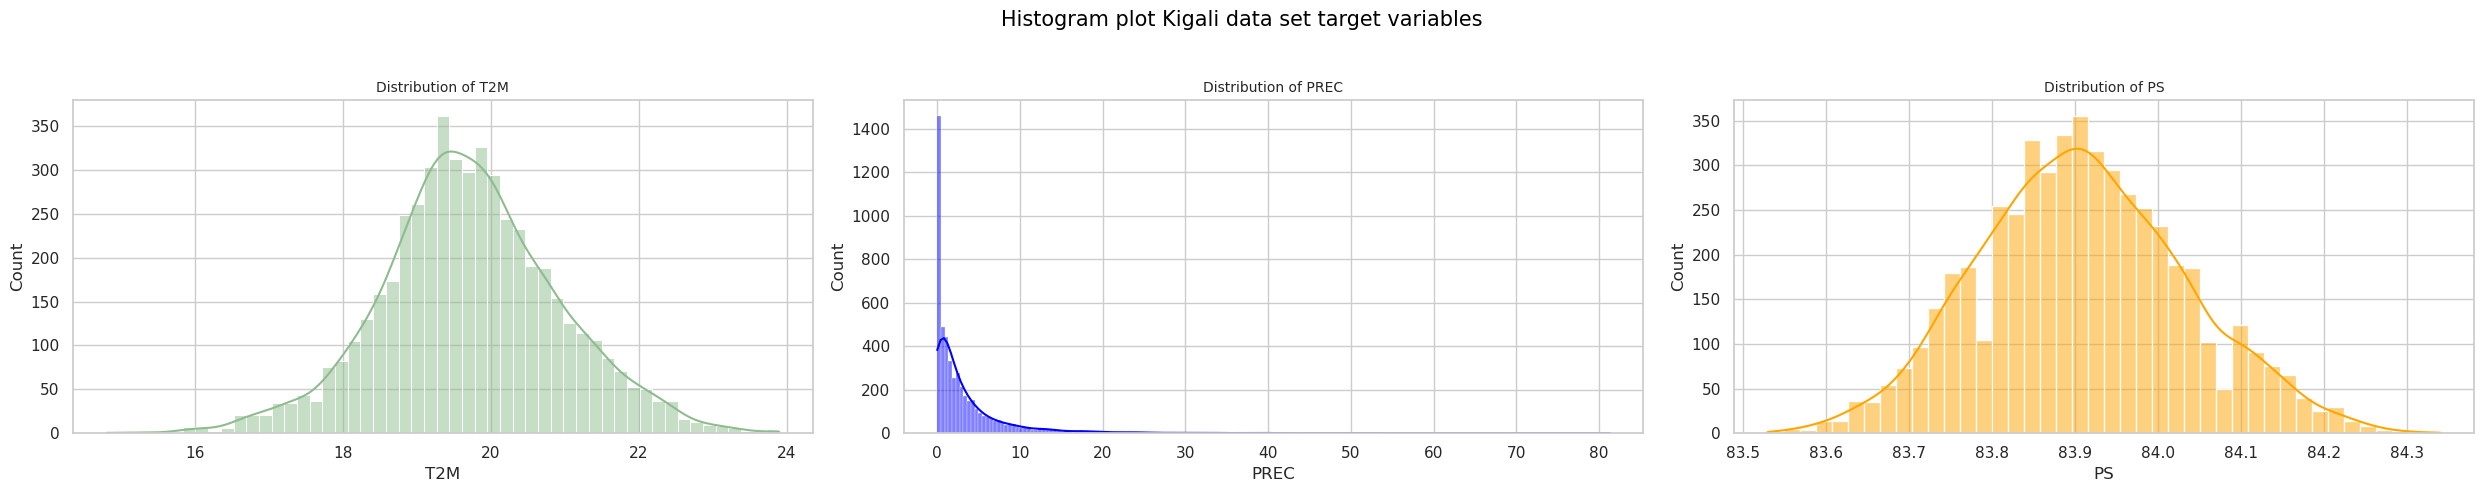

In [944]:
#Handle missing values
showDistributions(Kgl_dt,["T2M","PREC","PS"],title="Histogram plot Kigali data set target variables")
# df = df.fillna(method='ffill')a  # Forward fill for simplicity, or use df.dropna() to remove rows with NaNs
# print(df.isnull().sum())  # Verify no missing values remain


### Kolmogorov Arnold Networks

In [1208]:

def Make_tidydata_for_kan(data,scaler,data_type="full"):
    if data_type=="full":
        data= data.sort_index()
        data[data.columns] = scaler.fit_transform(data[data.columns])
        # print("data:",data.shape)
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return [Xy_train,Xy_val,Xy_test]

def data_loading(Xy):
    # Define the data 
    X,y=Xy.values[:,:-1],Xy.values[:,-1]
    X = torch.tensor(X, dtype=torch.float32)  # Convert to float32
    y = torch.tensor(y, dtype=torch.float32)  # Convert to float32
    # Create DataLoader
    batch_size = 64
    _dataset = TensorDataset(X, y.reshape(-1, 1))
    _loader = DataLoader(_dataset, batch_size=batch_size, shuffle=False)
    return  _loader 

In [1187]:
# os.path.exists("/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models")
# os.getcwd()

In [1209]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

var_to_pred = ['T2M','PS','PREC']

def train_test_loop_per_var(data, epochs,scaler, city="Kigali",layers_hidden=[9, 19,39, 1]):
    models = {}
    training_losses = {var: [] for var in var_to_pred}
    val_losses = {var: [] for var in var_to_pred}
    test_loaders = {var: [] for var in var_to_pred}
    dict_dates={var: [] for var in var_to_pred}
    for idx, var_name in enumerate(var_to_pred):
        # Work on a copy to avoid modifying the original data
        data_copy = data.copy()
        target_col = data_copy.pop(var_name)
        data_copy.insert(len(data_copy.columns), var_name, target_col)
        # 
        dates=data_copy.index.astype(str).tolist()
        # Create loaders
        list_data = Make_tidydata_for_kan(data_copy,scaler[idx])
        dict_dates[var_name].extend(Make_tidydata_for_kan(dates, scaler[idx],data_type="dates"))
        # train_loader, val_loader, test_loader = data_loading(np.array(list_data))
        train_loader, val_loader, test_loader = [data_loading(data) for data in list_data]

        test_loaders[var_name]=test_loader
        # Model Definition
        Kan_network = KAN(layers_hidden=layers_hidden).to(torch.float32)

        # Define loss and optimizer
        criterion = nn.MSELoss()  # Regression loss
        optimizer = torch.optim.Adam(Kan_network.parameters(), lr=0.001)
        Kan_network.train()
        # Epoch loop
        for epoch in range(epochs):
            epoch_train_loss = 0
            epoch_val_loss = 0

            # Training loop
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                #reg=sum(torch.norm(p) ** 2 for p in Kan_network.parameters()) 
                y_pred = Kan_network(X_batch, update_grid=False)  # Only update grid on first epoch
                loss = criterion(y_pred, y_batch) #+0.001*reg
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            loss_cum_train = epoch_train_loss / len(train_loader)
            training_losses[var_name].append(loss_cum_train)

            # Validation loop
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred_ = Kan_network(X_batch, update_grid=False)  # No need to update grid in validation
                    loss = criterion(y_pred_, y_batch)
                    epoch_val_loss += loss.item()
                
                loss_cum_val = epoch_val_loss / len(val_loader)
                val_losses[var_name].append(loss_cum_val)

            if epoch % 50 == 0:
                print(f"Epoch [{epoch}/{epochs}], Variable: {var_name} MSE Train Loss: {loss_cum_train:.4f}")
                print(f"MSE Validation Loss: {loss_cum_val:.4f}")

        print(f"Training complete for {var_name} {city}! 🚀")
        models[var_name] = Kan_network
        torch.save(Kan_network,f"/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/Models/{city}_Kan_network_{var_name}.pt")
    return models,test_loaders, training_losses, val_losses,dict_dates





In [1210]:
# # Scaler
scaler1 = [MinMaxScaler(feature_range= (0,1)) for i in  range(3) ] #(-1,1) if i==1 else
scaler2 = [MinMaxScaler(feature_range=(0,1)) for i in  range(3) ] #(-1,1) if i==1 else
# Training for Abidjan data
data_Abj, epochs=Abj_dt,100
models_Abj,test_loaders_Abj, training_losses_Abj, val_losses_Abj,dict_dates_Abj=train_test_loop_per_var(data_Abj, epochs,scaler1, city="Abidjan",layers_hidden=[9, 19, 1])
# Training for Kigali data
data_Kgl=Kgl_dt
models_Kgl,test_loaders_Kgl, training_losses_Kgl, val_losses_Kgl,dict_dates_Kgl=train_test_loop_per_var(data_Kgl, epochs,scaler2,city="Kigali", layers_hidden=[9, 19, 1])

Epoch [0/100], Variable: T2M MSE Train Loss: 0.1148
MSE Validation Loss: 0.0299
Epoch [50/100], Variable: T2M MSE Train Loss: 0.0001
MSE Validation Loss: 0.0001
Training complete for T2M Abidjan! 🚀
Epoch [0/100], Variable: PS MSE Train Loss: 0.0764
MSE Validation Loss: 0.0295
Epoch [50/100], Variable: PS MSE Train Loss: 0.0141
MSE Validation Loss: 0.0159
Training complete for PS Abidjan! 🚀
Epoch [0/100], Variable: PREC MSE Train Loss: 0.0060
MSE Validation Loss: 0.0061
Epoch [50/100], Variable: PREC MSE Train Loss: 0.0027
MSE Validation Loss: 0.0037
Training complete for PREC Abidjan! 🚀
Epoch [0/100], Variable: T2M MSE Train Loss: 0.0882
MSE Validation Loss: 0.0217
Epoch [50/100], Variable: T2M MSE Train Loss: 0.0001
MSE Validation Loss: 0.0000
Training complete for T2M Kigali! 🚀
Epoch [0/100], Variable: PS MSE Train Loss: 0.1010
MSE Validation Loss: 0.0261
Epoch [50/100], Variable: PS MSE Train Loss: 0.0165
MSE Validation Loss: 0.0158
Training complete for PS Kigali! 🚀
Epoch [0/100], 

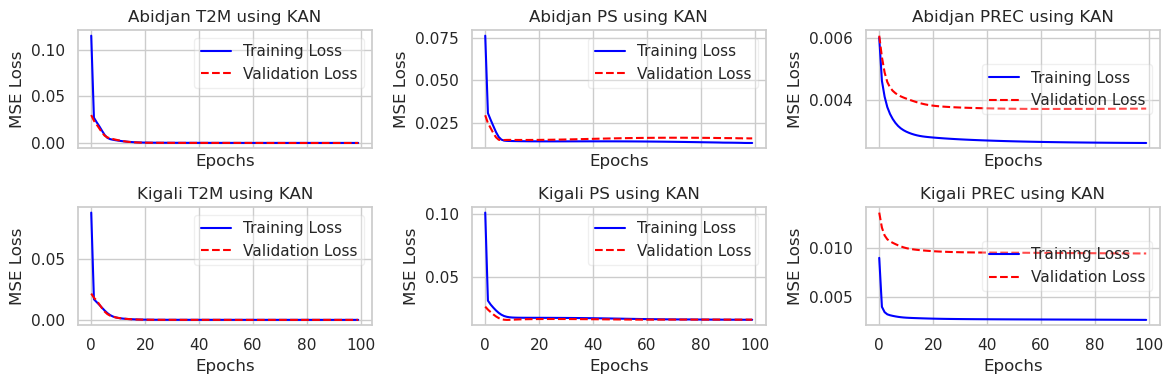

In [1211]:
import matplotlib.pyplot as plt

# Define city-specific data
cities = ["Abidjan", "Kigali"] #"
training_losses = [training_losses_Abj, training_losses_Kgl]#
val_losses = [val_losses_Abj, val_losses_Kgl] #
# var_to_pred=["PS"]
# Create subplots
fig, axes = plt.subplots( len(cities),len(var_to_pred), figsize=(12, 4), sharex=True, sharey=False)

for row, (city, train_loss, val_loss) in enumerate(zip(cities, training_losses, val_losses)):
    for col, var in enumerate(var_to_pred):
        ax = axes[row, col]
        
        # Plot training & validation loss
        ax.plot(train_loss[var], label="Training Loss", color="blue")
        ax.plot(val_loss[var], label="Validation Loss", color="red", linestyle="--")
        
        ax.set_title(f"{city} {var} using KAN")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("MSE Loss")
        ax.legend(framealpha=0.3)
        # Adjust text transparency
        if var=="PREC" and city in ["Kigali","Abidjan"]:
            ax.legend(framealpha=0.3,loc="center right")
            # legend = ax.legend(framealpha=0.3)  # Set background transparency
            # for text in legend.get_texts():
            #     text.set_alpha(0.9)  
        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [1212]:
dict_m={"Abidjan":[models_Abj,test_loaders_Abj,dict_dates_Abj], "Kigali": [models_Kgl,test_loaders_Kgl, dict_dates_Kgl]}
cities = ["Abidjan", "Kigali"]
scalers=[scaler1,scaler2]

In [1213]:



# f = lambda x: x # (1 / 8)



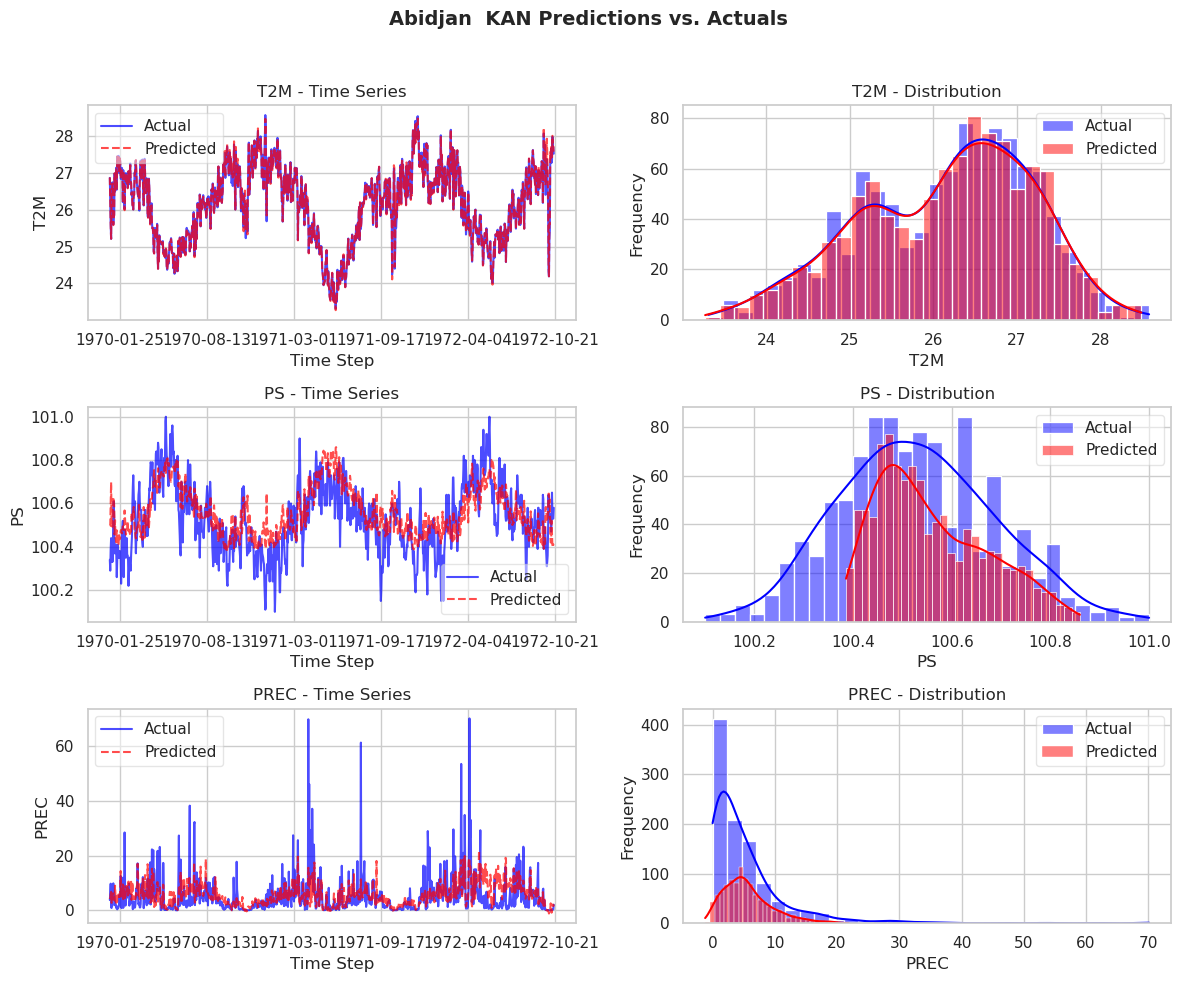

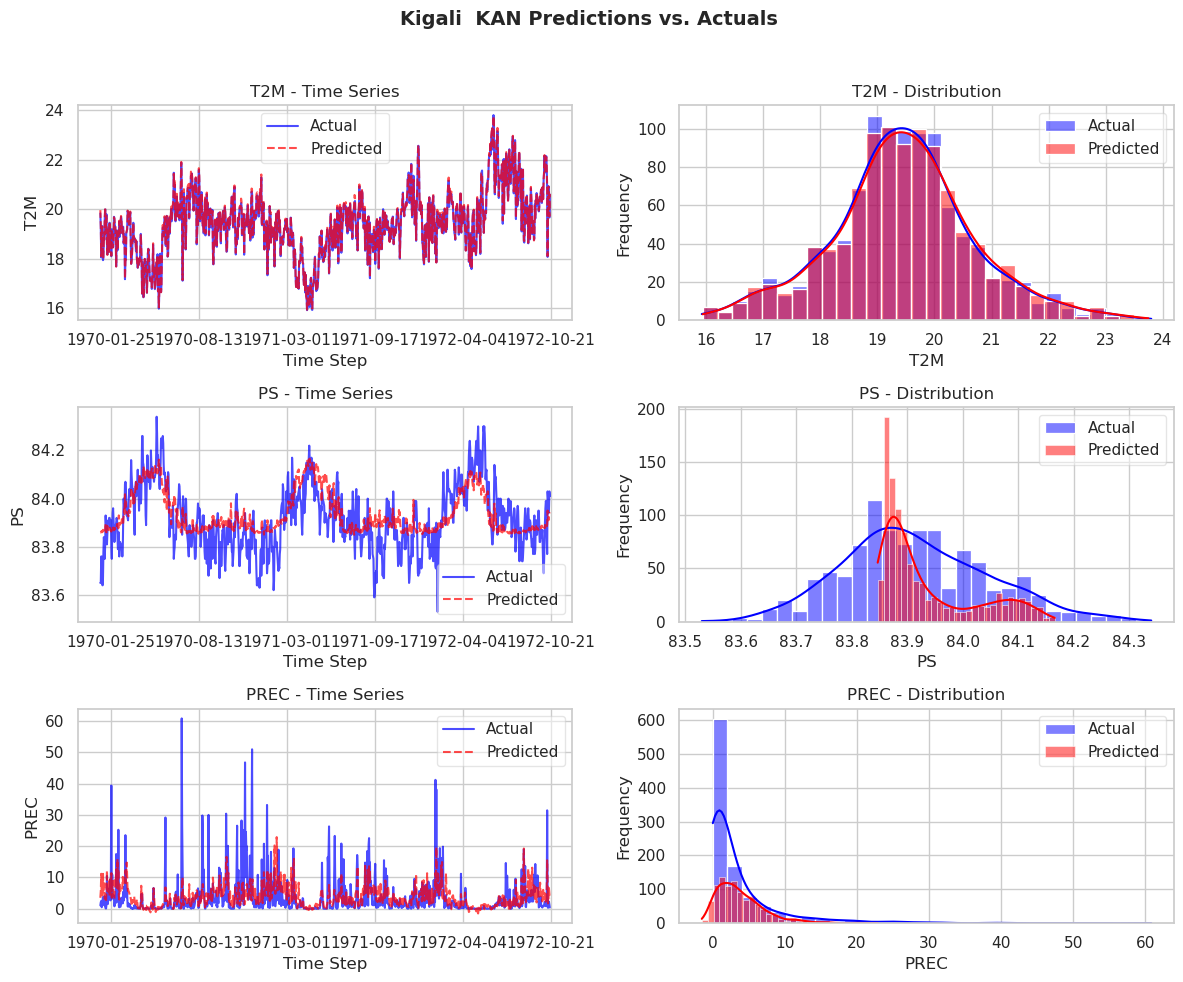

In [1214]:
# models_Abj

kan_metrics=kan_prediction_plots(dict_m, cities,scalers,model_name="KAN",var_to_pred =var_to_pred)
kan_metrics.to_csv("kan_metrics.csv")